# Rainfall retreival

In [1]:
import xarray as xr
import datatree
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.transforms as mtransforms
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap

2024-04-12 10:45:02.658084: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 10:45:02.662208: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 10:45:02.715188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 10:45:04.326826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# setting up the Seaborne style including figure  dpi
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")

### Local Cluster

Let's spin up our `Dask` local cluster

In [3]:
cluster = LocalCluster()  
# display(cluster)

## Data

CAMP2Ex dataset is stored in Analysis-Ready Cloud-Optimized (ARCO) format ([Abernathey et al. 2021](https://ieeexplore.ieee.org/document/9354557)) using [Xarray-Datatree](https://xarray-datatree.readthedocs.io/en/latest/) data model that allows us to have both Learjet and P3B datasets in one `datatree`. Climate and Forecast [(CF)](https://cfconventions.org/) were used to promote the processing and sharing of files created. Results from [K-means cluster](1.K-means-psd.ipynb)  analysis are also loaded into a `Pandas.Dataframe`

In [4]:
path_data = '../data/camp2ex_dtree.zarr'
dt_camp2ex = datatree.open_datatree(path_data, engine='zarr', consolidated=True)
path_kmeans = '../data/df_cluster.parquet'
df = pd.read_parquet(path_kmeans)

## Deep Neural Network

Our DNN was already trained in [PSD DNN](2.PSD_DNN_Training.ipynb). Thus, we can load the saved model as follows

In [5]:
model = tf.keras.models.load_model(f"../data/dnn_zku_Dfr_temp_ka_16x6.keras")

Simlarly, data for training and testing is copied into `X` variable. `Y` variable is use for data labeling and targeting

In [6]:
X = df[['dbz_t_ku', 'dfr', 'temp', 'Att_ka', 'log10_nw', 'dm', 'mu_unc']]
Y = df[['dm_class',  'r', 'kmeans', 'time', 'r_dm_gm_mu_3', 'r_gpm_operational', 
        'dm_rt_dfr_gm_mu_3', 'log10nw_dm_gm_mu_3', 'mu_3']]

Let's transform our input parameters by removing the mean and scaling to unit variance using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from the `Sklearn` Python package as follows

In [7]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'mu_unc']])

Data is splitted into `X_train` and `X_test` as follows

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=40, stratify=df.kmeans)
X_train.shape

(6321, 7)

We can use the `X_test` variable to predict the quantities after training our DNN.

In [9]:
yhat = model.predict(X_test[:, :4])

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


DNN input data is scaled. Therefore, we need to apply and inverse transformation. Similarly, data need to be inversely tranformed for the test dataset 

In [10]:
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

## NGSD parameter retrieval comparison

To compare the NGSD parameters we can create a `pandas.DataFrame` to store results

**Test dataset dataframe**

In [12]:
df_test = pd.DataFrame(data=y_test_unscaled, columns=['log10_nw', 'dm', 'mu'])

**Inference parameters dataframe**

In [13]:
df_est = pd.DataFrame(data=yhat, columns=['log10_nw_hat', 'dm_hat', 'mu_hat'])

We can merge/concatenate both dataframes into a single `pandas.DataFrame`

In [14]:
df_dnn = pd.concat([df_test, df_est, y_test['kmeans'].reset_index()], axis=1)

NGSD parameter retrieval is assessed using:

$$error =y - \hat{y}$$

Mean Absolute Error (MAE) 

$$MAE = 100* \lvert  \frac{y - \hat{y}}{y} \rvert$$

Where $y$ is the "true" value and $\hat{y}$ is the estimate value

In [15]:
df_dnn['dm_error'] = 100 * (df_dnn['dm'] - df_dnn['dm_hat']) /  df_dnn['dm']
df_dnn['dm_error_abs'] = df_dnn['dm'] - df_dnn['dm_hat']
df_dnn['log10_nw_error'] = 100 * (df_dnn['log10_nw'] - df_dnn['log10_nw_hat']) /  df_dnn['log10_nw']
df_dnn['log10_nw_error_abs'] = df_dnn['log10_nw'] - df_dnn['log10_nw_hat']
df_dnn['mu_error'] = 100 * (df_dnn['mu'] - df_dnn['mu_hat']) /  df_dnn['mu']
df_dnn['mu_error_abs']  = df_dnn['mu'] - df_dnn['mu_hat']

Targeting and labeling variables were stored in `Y`, as well as GPM baseline retrievals computed beforehand. We can create a `pandas.DataFrame` with this information

In [16]:
df_gpm = pd.concat([df_test, y_test.reset_index()], axis=1)

Similarly, we can compute the performance metrics for each legacy retrieval method

In [17]:
df_gpm['dm_error'] = 100 * (df_gpm['dm'] - df_gpm['dm_rt_dfr_gm_mu_3']) /  df_gpm['dm']
df_gpm['dm_error_abs'] = df_gpm['dm'] - df_gpm['dm_rt_dfr_gm_mu_3']
df_gpm['log10_nw_error'] = 100 * (df_gpm['log10_nw'] - df_gpm['log10nw_dm_gm_mu_3']) /  df_gpm['log10_nw']
df_gpm['log10_nw_error_abs'] = (df_gpm['log10_nw'] - df_gpm['log10nw_dm_gm_mu_3'])
df_gpm['mu_error'] = 100 * (df_gpm['mu'] - df_gpm['mu_3']) /  df_gpm['mu']
df_gpm['mu_error_abs']  = (df_gpm['mu'] - df_gpm['mu_3'])

Interquantile ranges (IQR) for DNN and GPM-baseline retreivals are computed as follows

In [18]:
dnn_iqrs = df_dnn[['dm_error', 'log10_nw_error', 'mu_error']].quantile([0.25, 0.5, 0.75])
gpm_iqrs = df_gpm.replace({'log10_nw_error': [np.inf, -np.inf]}, np.nan)[['dm_error', 'log10_nw_error', 'mu_error']].quantile([0.25, 0.5, 0.75])

keys = ['DNN', "GPM-baseline"]
pd.concat([dnn_iqrs, gpm_iqrs], axis=1, levels=[keys], keys=keys)

DNN                           GPM-baseline                 \
      dm_error log10_nw_error   mu_error     dm_error log10_nw_error   
0.25 -9.111483      -3.145742  -5.868922   -83.481112    -829.217567   
0.50  0.910358      -0.055934   1.832038   -42.285792    -735.991101   
0.75  7.714444       2.753824  10.702724    -9.106245    -657.651528   

                  
        mu_error  
0.25    2.594954  
0.50  204.166461  
0.75  265.518387

Similarly, we can compute the MAE standard deviation for each parameter

In [19]:
dnn_std = df_dnn[['dm_error_abs', 'log10_nw_error_abs', 'mu_error_abs']].std()
gpm_std = df_gpm.replace({'log10_nw_error_abs': [np.inf, -np.inf]}, np.nan)[['dm_error_abs', 'log10_nw_error_abs', 'mu_error_abs']].std()

keys = ['DNN', "GPM-baseline"]
pd.concat([dnn_std, gpm_std], axis=1, levels=[keys], keys=keys)

,DNN,GPM-baseline
dm_error_abs,0.095611,0.337101
log10_nw_error_abs,0.300144,13.795388
mu_error_abs,0.362387,2.649027


We added a new column with the retrieval source that will allow us to create violing plots using [`seaborn.violinplot`](https://seaborn.pydata.org/generated/seaborn.violinplot.html) colored by source 

In [20]:
df_dnn['source'] = "DNN"
df_gpm['source']  = "GPM-Analytical"

We merge both error dataframes into a single dataframe for plotting purposes

In [21]:
# Columns that contain errors for each parameter
cols = ['dm_error', 'dm_error_abs', 'log10_nw_error', 'log10_nw_error_abs', 'mu_error', 'mu_error_abs', 'kmeans', 'source']

# New merge dataframe
df_plot= pd.concat([df_dnn[cols], df_gpm[cols]], axis=0).reset_index()

## Plotting results

Let's define some figure settings such as colormaps.

In [22]:
# defining the Colormap for each cluster identified
n_c = 6
my_cmap6 = ListedColormap(sns.color_palette('deep', 6))
colors6 = my_cmap6(np.linspace(0,1,6))

We created violin plots to visualize error density distribution for each PSD family across each parameter retreived as follows

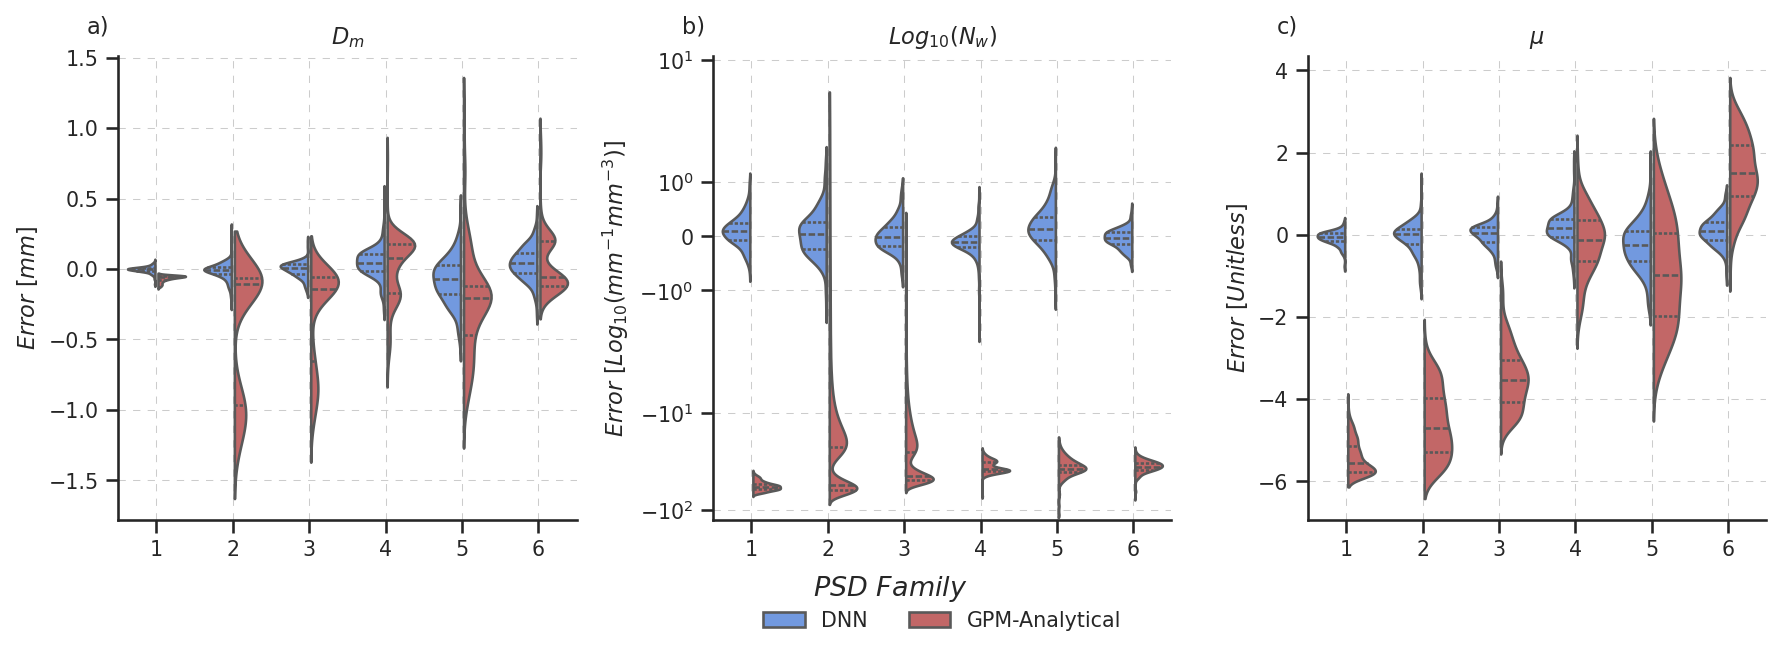

In [47]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)']], figsize=(12,5), dpi=150, sharex=True)

# Dm plot
ax = axs['a)']
g = sns.violinplot(data=df_plot, x='kmeans', y='dm_error_abs', hue='source', 
                   palette=['cornflowerblue', 'indianred'], saturation=0.8,
                   ax=ax, gap=.1, inner="quart", density_norm='width', legend=False, 
                   split=True)


ax.set_ylabel(r"$Error \ [mm]$")
ax.set_xlabel('')
ax.set_title(r"$D_m$")#, y=1.0, pad=30)


# Nw Plot
ax1 = axs['b)']
sns.violinplot(data=df_plot, x='kmeans', y='log10_nw_error_abs', hue='source', 
               palette=['cornflowerblue', 'indianred'], saturation=0.8,
                ax=ax1, gap=.1, inner="quart", density_norm='width', legend=True, split=True)
# ax1.set_yscale('symlog')
ax1.set_ylabel(r"$Error \ [Log_{10}(mm^{-1}mm^{-3})]$")
ax1.set_title(r"$Log_{10}(N_w)$")# , y=1.0, pad=30)
ax1.set_xlabel('')
sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, -0.28), ncol=2, title=None, frameon=False)


# Mu plot
ax2 = axs['c)']
sns.violinplot(data=df_plot, x='kmeans', y='mu_error_abs', hue='source', 
               palette=['cornflowerblue', 'indianred'], saturation=0.8,
                ax=ax2, gap=.1, inner="quart", density_norm='width', legend=False, split=True)
ax1.set_yscale('symlog')
ax2.set_ylabel(r"$Error \ [Unitless]$")
ax2.set_title(r"$\mu$")# , y=1.0, pad=30)
ax2.set_xlabel('')

ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
fig.supxlabel(r"$PSD \ Family$", y= 0.195)

sns.despine()
fig.tight_layout()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-15/72, 20/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
    
plt.savefig('../images/violin_ngsd_parm.svg',  bbox_inches='tight')

## Rainfall rate estimation

Finally, the rainfall rate is estimated using the NGSD parameters as follows, 

$$R = \frac{\pi}{6*10^{-3}} \rho_w  \int_{D_{min}}^{D_{max}} N_w N(D)D^3v(D)dD \,dx$$

where 

$$N(D)= N_w f(D_m, \mu)$$
$$N_w = \frac{4^4}{\pi\rho_w} \left( \frac{LWC}{D_m^{4}} \right)$$
$$f(D_m, \mu) = \frac{6}{4^4} \frac{(\mu+4)^(\mu + 4))}{\Gamma(\mu + 4)} \left(\frac{D}{D_m} \right)^{\mu}exp^{\left[(\mu + 4) \frac{D}{D_m})\right]}$$
$$v(D) = 3.78 * D ^{0.67}$$

Now we can translate this equations into the following code

In [ ]:
def norm_gamma(d, nw, mu, dm):
    """
    Function that compute the normalized-gamma size distribution (Testud et al., 2002)
    Param d: diameter in mm
    Param nw: Normalized intercept parameter
    Param mu: Shape parameter
    Param dm: Mass-weighted mean diameter
    """
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

def rain_retrieval(nw, mu, dm, d, d_d, vel_m='lerm'):
    """
    Function that computes rainfall rates from the NGSD parameters
    Param d: diameter in mm
    Param nw: Normalized intercept parameter
    Param mu: Shape parameter
    Param dm: Mass-weighted mean diameter
    Param d_d: bin size width in mm
    Param vel_m: velocity parameterization method
    """
    lerm_vel: Callable[[float], float] = lambda diam: 9.25 * (1 - np.exp(-0.068 * diam ** 2 - 0.488 * diam))  # d in mm
    ulbr_vel: Callable[[float], float] = lambda diam: 3.78 * diam ** 0.67  # with d in mm
    if vel_m == 'lemr':
        vel = lerm_vel(d)
    else:
        vel = ulbr_vel(d)
    f_mu = (6 * (mu + 4) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4))
    r = 6 * np.pi * 1e-4 * (nw * f_mu * (d / dm) ** mu * np.exp(-(4 + mu) * (d / dm)) * vel * d ** 3 * d_d)
    return r.sum('diameter')

We can use the advantages of `xarray` to cast data into our functions and compute rainfall values. Therefore, we create `xarray.Dataset` to store NGSD parameter

In [52]:
#Nw retrieved parameter
nw = yhat[:, 0]

#Dm retreived parameter
dm = yhat[:, 1]

#Uncorrelated Mu retreived parameter
mu_unc = yhat[:, 2]

# xarray dataset
ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu_unc = (["time"], mu_unc),
    ), 
    coords=dict(
        time=(["time"], y_test.time.values),
        diameter=(['diameter'], dt_camp2ex['Lear'].ds.diameter.values)
    ),
)

Adding PSD bin size width to our new Dataset

In [ ]:
d_d = dt_camp2ex['Lear'].ds.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d, dims=['time', "diameter"])
ds_sub['d_d'] = d_d

Adding Kmeans cluster number to our new Dataset

In [ ]:
kmeans = xr.DataArray(data= y_test.kmeans.values, dims=['time'])
ds_sub['kmeans'] = kmeans

Now, we can pass our NGSD retieved parameters ($N_w$, $D_m$ and $\mu_{unc}$) to our `rain_retreival` function what will return an `xarray.DataArray`

In [55]:
nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm, 
                         d=ds_sub.diameter / 1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

Adding the Kmeans labels as coordinates

In [59]:
nn_rain['kmeans'] = ds_sub['kmeans']

Similarly, we can create `pandas.DataFrame` for each rainfall retreival incluiding DNN, GPM-Analytical, GPM-Operational, and the "true" values. Moreover, error and MAE are estimated
**True dataset**

In [60]:
df_r = y_test[['r', 'kmeans']].reset_index(drop=True)
df_r['source'] = "True"

**DNN dataset**

In [27]:
df_dnn_r = nn_rain.to_dataframe('r_dnn')[['r_dnn','kmeans']].reset_index(drop=True)
df_dnn_r['source'] = "DNN"
df_dnn_r['r_ae'] = df_r.r - df_dnn_r.r_dnn
df_dnn_r['r_mpe'] = 100 * (df_r.r - df_dnn_r.r_dnn) / df_r.r 

**GPM-Analytical dataset**

In [ ]:
df_gpm_ana_r = y_test[['r_dm_gm_mu_3','kmeans']].reset_index(drop=True)
df_gpm_ana_r['r'] = df_r.r
df_gpm_ana_r['r_ae'] = df_r.r - df_gpm_ana_r.r_dm_gm_mu_3
df_gpm_ana_r['r_mpe'] = 100 * (df_r.r - df_gpm_ana_r.r_dm_gm_mu_3) /  df_r.r
df_gpm_ana_r['source'] = "GPM-Analytical"

In [ ]:
**GPM-OPerational Dataset dataset**

In [ ]:
df_gpm_op_r = y_test[['r_gpm_operational','kmeans']].reset_index(drop=True)
df_gpm_op_r['r_ae'] = df_r.r - df_gpm_op_r.r_gpm_operational
df_gpm_op_r['r_mpe'] = 100 * (df_r.r - df_gpm_op_r.r_gpm_operational) /  df_r.r
df_gpm_op_r['source'] = "GPM-Operational"

In [29]:
cols = ['kmeans', 'r_ae', 'r_mpe', 'source']
df_rain_err = pd.concat([df_dnn_r[cols], df_gpm_ana_r[cols], df_gpm_op_r[cols]], axis=0).reset_index(drop=True)

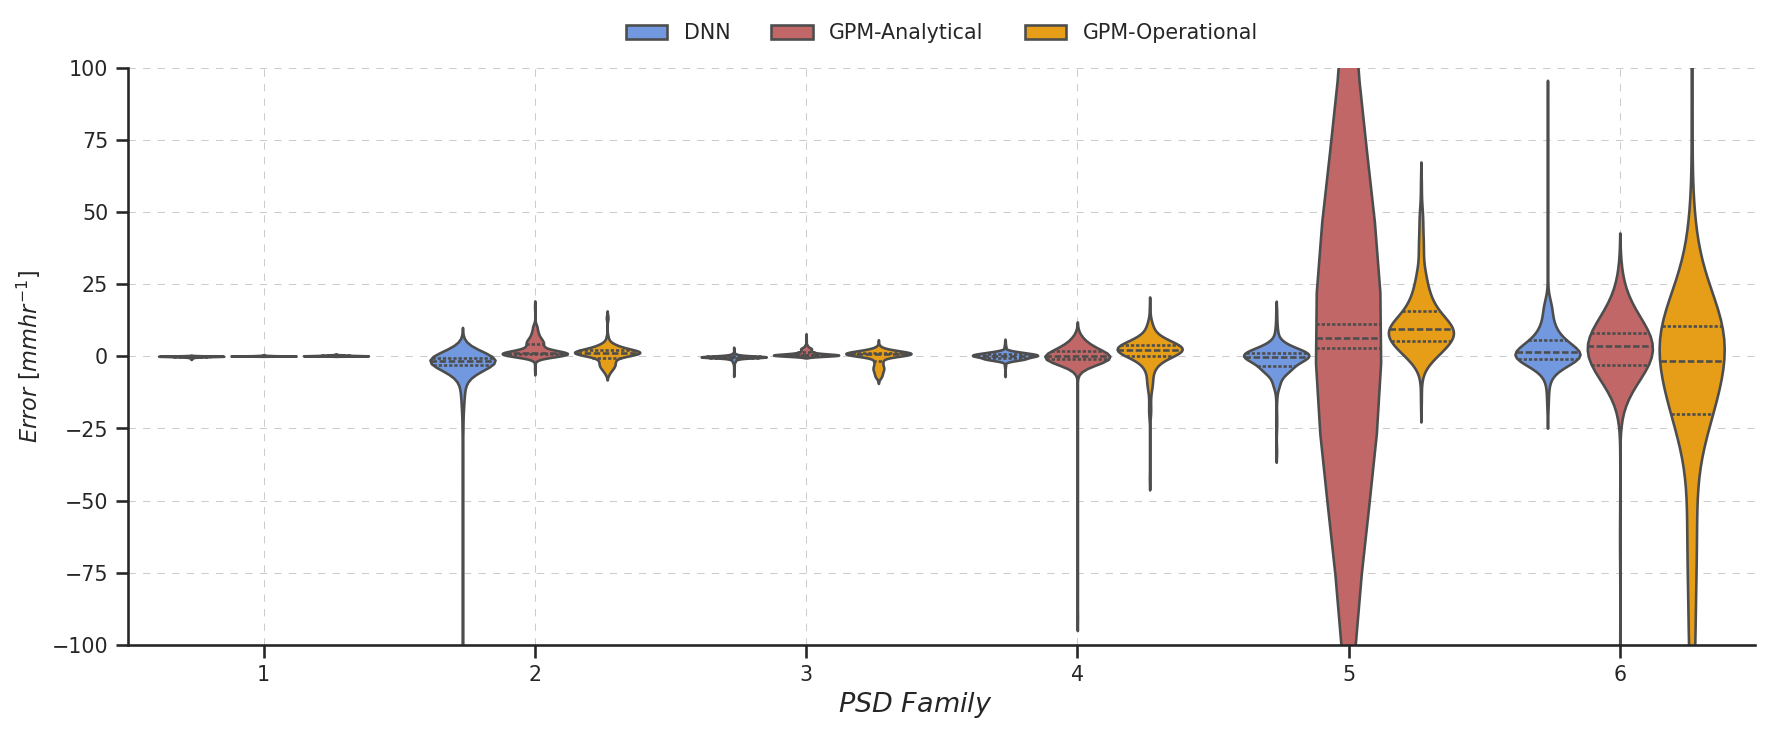

In [33]:
fig, ax = plt.subplots(figsize=(14,5), dpi=150)
g = sns.violinplot(data=df_rain_err, x='kmeans', y='r_ae', hue='source', 
                   palette=[ 'cornflowerblue','indianred', 'orange',], 
                   saturation=0.8,
                   ax=ax, gap=.1, inner="quart", density_norm='width', 
                   legend=True,
                   )
ax.set_ylabel(r"$Error \ [mmhr^{-1}]$")
ax.set_xlabel('')
# ax.set_yscale('symlog')
# ax.set_ylim(-1e4, 1e4)
ax.set_ylim(-100, 100)
sns.despine()
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
fig.supxlabel(r"$PSD \ Family$")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.01), ncol=3, title=None, frameon=False)
plt.savefig('../images/violin_rain_parm.svg',  bbox_inches='tight')

In [35]:
df_dnn_r[['r_ae', 'r_mpe']].quantile([0.25, 0.5, 0.75])

,r_ae,r_mpe
0.25,-0.811450,-40.915018
0.50,-0.120516,-8.944202
0.75,0.290556,10.004977


In [36]:
 df_dnn_r[['r_ae', 'r_mpe']].std()

r_ae      5.424153
r_mpe    95.704057
dtype: float64

In [37]:
df_gpm_ana_r[['r_ae', 'r_mpe']].quantile([0.25, 0.5, 0.75])

,r_ae,r_mpe
0.25,0.089867,26.801436
0.50,0.447630,46.018890
0.75,2.803241,65.618532


In [38]:
df_gpm_ana_r[['r_ae', 'r_mpe']].std()

r_ae      59.172139
r_mpe    679.718485
dtype: float64

In [39]:
df_gpm_op_r[['r_ae', 'r_mpe']].quantile([0.25, 0.5, 0.75])

,r_ae,r_mpe
0.25,0.090489,18.225238
0.50,0.605111,90.553720
0.75,2.750007,99.921940


In [40]:
df_gpm_op_r[['r_ae', 'r_mpe']].std()

r_ae      15.092566
r_mpe    147.507713
dtype: float64

In [41]:
def metrics_pd(x, xpred):
    """
    Function that computes the Root Mean Square Error, the Mean Absolute Error 
    and the Correlation Coefficient between the 'True' parameter and the estimate parameter
    param x: True parameter values
    param xpred: Estimated parameter values
    """
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    xpred = xpred[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

In [42]:
# dnn
rmse, mae, corr1 = metrics_pd(df_r.r, df_dnn_r.r_dnn)
rmse, mae, corr1

(5.426361194211503, 1.966917474261711, 0.8677994916446448)

In [43]:
# GMP_ana
rmse, mae, corr1 = metrics_pd(df_r.r, df_gpm_ana_r.r_dm_gm_mu_3)
rmse, mae, corr1

(59.154316009454874, 5.214079950345238, 0.049554875690808416)

In [44]:
# GMP_ope
rmse, mae, corr1 = metrics_pd(df_r.r, df_gpm_op_r.r_gpm_operational)
rmse, mae, corr1


(15.100147718845225, 6.110706254259326, 0.36543226410708624)

In [45]:
df_rain_err.describe()

,kmeans,r_ae,r_mpe
count,4743.000000,4437.000000,4437.000000
mean,3.320683,-0.061419,1.891099
std,1.697074,34.789869,399.570318
min,1.000000,-2151.311271,-25057.031759
25%,2.000000,-0.291242,-13.958651
50%,3.000000,0.221722,28.448262
75%,5.000000,1.608886,69.450506
max,6.000000,129.278005,100.000000


In [46]:
df_gpm_op_r.describe()

,r_gpm_operational,kmeans,r_ae,r_mpe
count,1428.000000,1581.000000,1428.000000,1428.000000
mean,7.518175,3.320683,0.623242,27.593594
std,18.356192,1.697432,15.092566,147.507713
min,0.000004,1.000000,-155.286414,-1194.026901
25%,0.000422,2.000000,0.090489,18.225238
50%,0.452059,3.000000,0.605111,90.553720
75%,6.693119,5.000000,2.750007,99.921940
max,168.541390,6.000000,129.278005,99.999871
